In [2]:
import os
from dotenv import load_dotenv
import h5py
import numpy as np
from matplotlib import pyplot as plt, gridspec

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']
result_dir_path = os.environ['RESULT_DIR_PATH']

## Recon Visualization

In [14]:
def show_image_with_recon(img_path, recon_path, slice_idx=0, cmap='gray'):
    img_keys = ['image_label']
    recon_key = 'reconstruction'
    img_title = img_path.split('/')[-1]
    
    # show image
    hf = h5py.File(img_path)
    plt.figure(figsize=(15, 8))
    plt.suptitle(f'{img_title} - slice {slice_idx}')
    for j, key in enumerate(img_keys):
        ax = plt.subplot(1, len(img_keys) + 1, j + 1)
        img_slice = hf[key][slice_idx]
        plt.title(key)
        ax.imshow(img_slice, cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    # show label
    hf = h5py.File(recon_path, 'r')
    ax = plt.subplot(1, len(img_keys) + 1, len(img_keys) + 1)
    recon_slice = hf[recon_key][slice_idx]
    plt.title(recon_key)
    ax.imshow(recon_slice, cmap=cmap)
    plt.axis('off')
    
    plt.show()

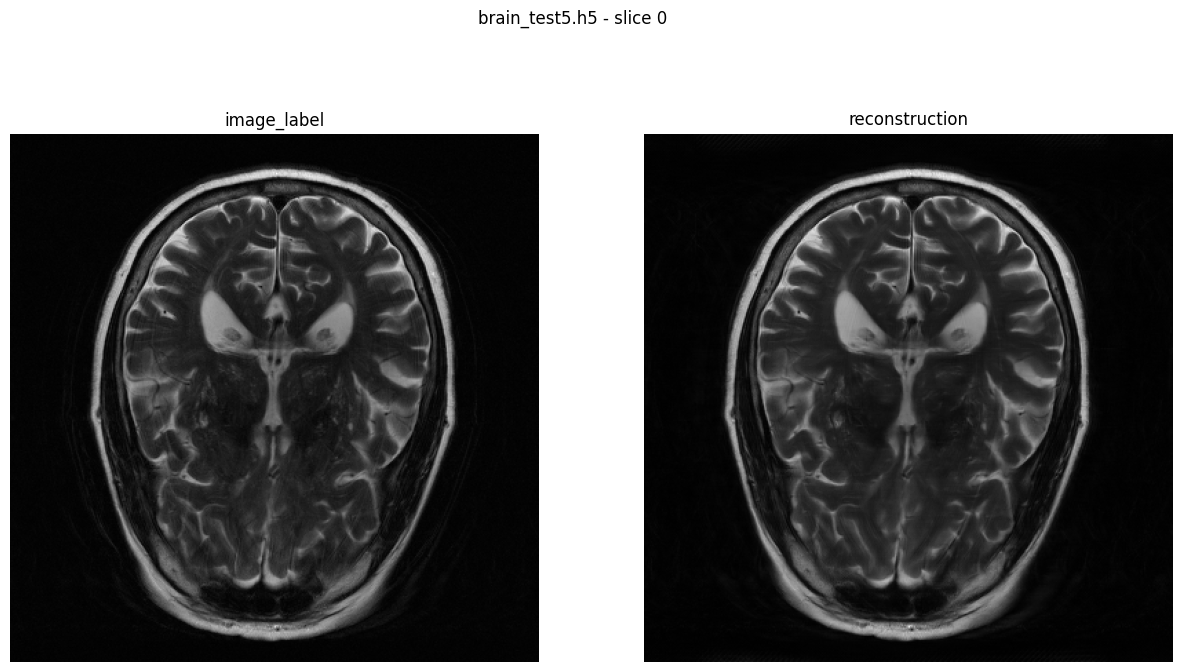

In [15]:
img_path = f'{data_dir_path}/leaderboard/acc5/image/brain_test5.h5'
recon_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard/public/brain_test5.h5'
show_image_with_recon(img_path, recon_path)

## Error Map